# **Regresión Lineal Múltiple para Bitcoin**

In [ ]:
pip install yfinance  

In [ ]:
#@title Importo las dos librerías que necesito.
import pandas as pd # La poderosa
import numpy as np # La segunda poderosa 
import matplotlib.pyplot as plt # La que grafica
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf # Pa traer la data de Yahoo Finance
from pandas_datareader import data as pdr # Pa leer la data
import datetime
pd.options.display.float_format = '{:.4f}'.format # Flotantes de 4 decimales.

In [ ]:
#@title  Carga de dataset
#Valid periods: 1d,5d,1mo,3mo,6mo,1y,5y,10y,ytd,max. PERIODO DE TIEMPO
#Valid intervals:1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo. TAMAÑO DE LA VELA
#df = yf.download('BTC-USD', start = '2017-08-01', end = '2021-12-27')
#ds_BTC = yf.download('BTC-USD', period = '1mo', interval = '5m') EL PRINCIPAL QUE USO
ds_BTC = yf.download('BTC-USD', period = '1mo', interval = '60m') #Uno chico
#ds_BTC.describe()
# Importante: Incluyo la cronología en una columna.
# Recordar que esto son series de tiempo.
ds_BTC['DateTime'] = ds_BTC.index 
# Acá reorganizo columnas para que el tiempo quede al ppio. 
cols_ds_BTC = list(ds_BTC.columns)
cols_ds_BTC
aux_cols = cols_ds_BTC[-1:] + cols_ds_BTC[:-1] 
aux_cols
ds_BTC = ds_BTC[aux_cols]
ds_BTC
#ds_BTC = ds_BTC[['DateTime','Open','High','Low','Close','Adj Close','Volume']]
# ds_BTC.style.hide_index() | Me falta borrar la columna index.

In [ ]:
#@title  Carga de otros indicadores, por ejemplo: S&P 500
# Si necesitás ajustar parámetros, podés guiaste con el paso anterior
ds_SPY = yf.download('SPY', period = '1mo', interval = '5m')
ds_SPY.rename(columns={
    'Open':'Open_SPY',
    'High':'High_SPY',
    'Low':'Low_SPY',
    'Close':'Close_SPY',
    'Adj Close':'Adj Close_SPY',
    'Volume':'Volume_SPY',
    },inplace=True)
ds_SPY
# Recordar que esto son series de tiempo.
ds_SPY['DateTime'] = ds_SPY.index 
# Acá reorganizo columnas para que el tiempo quede al ppio. 
cols_ds_SPY = list(ds_SPY.columns)
#cols_ds_SPY
aux_cols = cols_ds_SPY[-1:] + cols_ds_SPY[:-1] 
#aux_cols
ds_SPY = ds_SPY[aux_cols]
#ds_SPY
# Uno todo en el dataset ppal 
# pd.merge(ds_BTC,ds_SPY, how="outer",left_index=True, right_index=True)
# pd.merge(ds_BTC,ds_SPY, on='DateTime')
papaya = pd.merge(ds_BTC,ds_SPY, on='DateTime')
papaya.head()

In [ ]:
ds_BTC['DateTime'] = ds_BTC.index # Importante: Incluyo la cronología en una columna
cols_ds_BTC = list(ds_BTC.columns)
cols_ds_BTC
#aux_cols = cols_ds_BTC[-1:]
#aux_cols
#ds_BTC = ds_BTC[['DateTime','Open','High','Low','Close','Adj Close','Volume']]
# ds_BTC.style.hide_index() | Me falta borrar la columna index.

## **1. Analisis exploratorio**

In [ ]:
#@title Encabezado del data set
ds_BTC.head()

In [ ]:
#@title Cantidad de filas para separar el dataframe en 80/20
cant_filas = ds_BTC.shape[0]  #cant_col = ds_BTC.shape[1]  
cant_filas_test =  int(cant_filas * 0.2)
cant_filas_entrenamiento = cant_filas - cant_filas_test

In [ ]:
#@title Matriz de correlación
ds_BTC.corr()

In [ ]:
#@title Gráficas de relaciones de variables con el precio
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ds_BTC.plot.scatter(x='Open', y='Close', ax=ax1)
ds_BTC.plot.scatter(x='High', y='Close', ax=ax2)
ds_BTC.plot.scatter(x='Low', y='Close', ax=ax3)
ds_BTC.plot.scatter(x='Volume', y='Close', ax=ax4);
#Definir título y nombres de ejes # ESTA MÁL. CORREGIR
plt.title('Relaciones con el precio de cierre')
plt.legend()
plt.show()

## **2. Modelo de regresión lineal múltiple**

$E(Y|X_1, X_2, ..., X_p) = \beta_0 + \beta_1 \cdot X_1 + \beta_2  \cdot X_2 + ... + \beta_p \cdot X_p $

In [ ]:
#@title Separo del dataset en X (variables predictoras) e y (variable a predecir)
#Acá saco el Volumen ajustado porque la definición aplica a acciones y no encontré explicación para criptos
X = ds_BTC[['Open', 'High', 'Low', 'Volume']]
y = ds_BTC['Close']

### **2.1 Preparación de los datos**

**Opción 1**: Usar la función [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Argumentos: 

El set de datos de variables predictoras

La serie de la variable a predecir y 

El % de datos que deseamos que forme nuestro set de evaluación.

In [ ]:
# Algunos comandos para visualizar y chequear que todo esté en orden
# X.head(), y.head(), type(X), type(y), X.shape, y.shape

In [ ]:
# Data sets de entrenamiento y testeo.
from sklearn.model_selection import train_test_split
SEMILLA = 1992
# Realizamos el split de X e y en los sets de entrenamiento (train) y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEMILLA)
print(f"El dataset de entrenamiento cuenta con {len(X_train)} observaciones")
print(f"El dataset de evaluación cuenta con {len(X_test)} observaciones")

El dataset de entrenamiento cuenta con 588 observaciones
El dataset de evaluación cuenta con 148 observaciones


**Opción 2**: Artesanalmente

In [ ]:
#@title Opción 2.  
#Selección ds_BTC_test tenida en cuenta como una serie de tiempo.
#Esto es importante ya que hay un orden cronológico en los datos.
ds_BTC_test = ds_BTC.iloc[0:cant_filas_test] 
#ds_BTC_test
X_test = ds_BTC_test[['Open', 'High', 'Low', 'Volume']]
y_test = ds_BTC_test['Close']

In [ ]:
#@title Selección ds_BTC_entrenamiento tenida en cuenta como una serie de tiempo
ds_BTC_entrenamiento = ds_BTC.iloc[cant_filas_test:] 
#ds_BTC_entrenamiento
X_train = ds_BTC_entrenamiento[['Open', 'High', 'Low', 'Volume']]
y_train = ds_BTC_entrenamiento['Close']

### **2.2 Obtención del modelo**

Probemos con **Open** y **High** como variables predictoras.
Tienen correlación. Así que...

$E(precio|.) = \beta_0 + \beta_1 \cdot Open + \beta_2 \cdot High$

In [ ]:
#@title Definimos las dos variables predictoras.
# Por qué esas dos? Por que si. Probemos:
var_predictoras = ['Open', 'High']

In [ ]:
#@title Construimos la matriz de X
X_train_modelo_2var = X_train[var_predictoras]
X_train_modelo_2var.head()

In [ ]:
#@title Importamos el modelo lineal y otras cosas.
# Modelo lineal
from sklearn.linear_model import LinearRegression
# Error cuadrático medio
from sklearn.metrics import mean_squared_error

In [ ]:
#@title Definimos una instancia del modelo lineal con scikit learn
LM_2var = LinearRegression(fit_intercept=True) # El fit_intercept=True es para jugar con el B0.

In [ ]:
#@title Entreno el modelo y obtengo los coeficientes/intercepto
#Entrenamiento:
LM_2var.fit(X_train_modelo_2var, y_train)
#Guardo coeficientes e intercepto:
coeficientes = LM_2var.coef_
intercepto = LM_2var.intercept_
#Separo los betas:
beta_1, beta_2 = coeficientes[0], coeficientes[1] 
print(f"Beta 1 = {beta_1:.4f}")
print(f"Beta 2 = {beta_2:.4f}")
print(f"El cruce por y = {intercepto:.4f}")

Beta 1 = -0.1948
Beta 2 = 1.2042
El cruce por y = -576.2782


In [ ]:
#@title Definimos una función para obtener los coeficientes en un dataframe
# Esto es opcional. Todavía no lo se.
def obtener_coeficientes(modelo, lista_variables):
  '''Crea un dataframe con los coeficientes estimados de un modelo'''
  # Creo la lista de nombres de variables
  lista_variables = ['intercepto'] + lista_variables
  # Intercepto
  intercepto = modelo.intercept_
  # Lista coeficientes excepto el intercepto
  coeficientes = list(modelo.coef_)
  # Lista completa coeficientes
  lista_coeficientes = [intercepto] + coeficientes
  return pd.DataFrame({"variable": lista_variables, "coeficiente": lista_coeficientes})

In [ ]:
# Obtenemos nuestro dataframe 
coeficientes_LM_2var = obtener_coeficientes(LM_2var, var_predictoras)
coeficientes_LM_2var

,variable,coeficiente
0,intercepto,-576.2782
1,Open,-0.1948
2,High,1.2042


In [ ]:
!pip install funpymodeling

In [ ]:
# Para transformar cualquier cosa en un data frame.
from funpymodeling.data_prep import todf 

In [ ]:
#@title Acá hago una predicción y lo almaceno en un dataset.
y_predicho = LM_2var.predict(X_test[var_predictoras])
y_predicho = todf(y_predicho)
y_predicho.rename(columns={0:'Predicho'},inplace=True)
y_predicho

,Predicho
0,51135.4565
1,51061.0489
2,50899.0715
3,50905.4689
4,51049.1975
...,...
141,47611.5615
142,47764.5744
143,47759.0860
144,47620.9512


In [ ]:
#@title Hago algunas modificaciones en la columna de testeo.
y_test = todf(y_test)
yaux = y_test
yaux['Precio de cierre'] = y_test['Close']
yaux = y_test.set_index('Close')
yaux = yaux.reset_index(drop=True)
yaux.head()

,Precio de cierre
0,51146.9414
1,50925.1875
2,50769.4141
3,50865.3555
4,51099.7422


In [ ]:
y_predicho.shape

(146, 1)

In [ ]:
yaux.shape

(146, 1)

In [ ]:
#@title Uno todo en un dataset 
df_y_testeo_predicho = pd.merge(yaux,y_predicho, how="outer",left_index=True, right_index=True)
df_y_testeo_predicho.head()

,Precio de cierre,Predicho
0,51146.9414,51135.4565
1,50925.1875,51061.0489
2,50769.4141,50899.0715
3,50865.3555,50905.4689
4,51099.7422,51049.1975


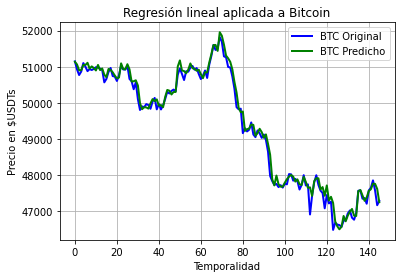

In [ ]:
#@title Acá quiero graficar la salida original vs la predicha
#Configuración de las características del gráfico
plt.plot(df_y_testeo_predicho['Precio de cierre'], label = 'BTC Original', linewidth = 2, color = 'blue')
plt.plot(df_y_testeo_predicho['Predicho'], label = 'BTC Predicho', linewidth = 2, color = 'green')
#Definir título y nombres de ejes
plt.title('Regresión lineal aplicada a Bitcoin')
plt.ylabel('Precio en $USDTs')
plt.xlabel('Temporalidad')
#Mostrar leyenda, cuadrícula y figura
plt.legend() # Para que imprima el label definido previamente.
plt.grid() # Traza grilla de fondo.
plt.show() # Lo muestra mas prolijo.


In [ ]:
# Algunos comandos para visualizar y chequear que todo esté en orden
# type(y_test), type(y_predicho)

In [ ]:
#@title Calculamos el error y el r2
error = np.sqrt(mean_squared_error(yaux,y_predicho))
r2 = LM_2var.score(X_train_modelo_2var, y_train)
print(f"El error es = {error:.4f}")
print(f"El r2 es = {r2:.4f}")

El error es = 172.5464
El r2 es = 0.9972


## 3. Vamos a evaluarlo!

En esta parte vamos a evaluar los resultados obtenidos por algunos de los modelos previos. Por un lado nos interesará observar los resultados de los tests estadísticos de significatividad individual y global y por el otro observar algunas métricas de performance


# -----------------------------------------------------------------------------------

# HASTA ACÁ LLEGUÉ. ABAJO ESTÁ LO QUE HAY QUE HACER CON LOS ERRORES. COMO CALCULARLOS Y TERMINO.

Luego: 
Separar en etapas: Lectura y depuración del DF.
Guardar los CSV que necesito.
Dejar opción de meter otro activos/indicador, por ejemplo el S&P500

Modelo:
Acá a idea es sacar un programa por modelo.
Y acá saco también lo predicho.
Resultados
Un paquete de resultados con los errores,
graficos,
y demás, independientemente del modelo.


### 4.1 Tests estadísticos

Para realizar la evaluación con un enfoque estadístico más tradicional debemos utilizar el modulo [statsmodels](https://www.statsmodels.org/stable/regression.html). Para poder acceder a la información que nos interesa vamos a tener que crear los modelos con esta librería.

La librería sklearn no cuenta con las funciones necesarias para realizar la evaluación de los tests estadísticos de los coeficientes estimados.

Comencemos preparando los datos para la implementación del modelo lineal en statsmodels



In [ ]:
# En statsmodels se le agrega el intercepto (en scikit se lo pasamos como un parametro a la instancia del modelo)
X_train_modelo_sup_baños_stats = sm.add_constant(X_train_modelo_sup_baños)
X_train_modelo_sup_baños_stats.head()

,const,surface_total,bathrooms
36377,1.00,63.00,1.00
8124,1.00,42.00,1.00
34075,1.00,160.00,1.00
28781,1.00,126.00,2.00
4876,1.00,32.00,1.00


In [ ]:
# Construimos el modelo
modelo_sup_baños_stats = sm.OLS(y_train, X_train_modelo_sup_baños_stats)

In [ ]:
# Guardamos los resultados
resultados_sup_baños_stats = modelo_sup_baños_stats.fit()

In [ ]:
# Accedemos a los coeficientes estimados
resultados_sup_baños_stats.params

const           -107213.66
surface_total      2069.78
bathrooms        113359.65
dtype: float64

En primer lugar observamos que los coeficientes estimados son iguales a los que obtuvimos utilizando la implementación de scikit learn.

Ahora veamos los p valores asociados a los tests de significatividad individual. Recordemos que las hipótesis son:

$H_0: \beta_j = 0$

$H_A: \beta_j \neq 0$

Para rechazar la hipótesis de que el parámetro es igual a cero debemos observar un p valor inferior a 0.05

In [ ]:
# Accedemos a los p valores de los tests de significancia individual
resultados_sup_baños_stats.pvalues

const           0.00
surface_total   0.00
bathrooms       0.00
dtype: float64

Continuamos con el test de significatividad global. Las hipotesis son:

$H_0: \text{Todos los } \beta_j = 0$

$H_A: \text{Algún } \beta_j \neq 0$


In [ ]:
# Test significatividad global
resultados_sup_baños_stats.f_pvalue

0.0

Observamos el R cuadrado y R cuadrado ajustado

In [ ]:
# R cuadrado
resultados_sup_baños_stats.rsquared

0.5713023987671959

In [ ]:
# R cuadrado ajustado
resultados_sup_baños_stats.rsquared_adj

0.5712757060987714

Toda esta información a la que fuimos accediendo (junto a mucha información más) se puede obtener imprimiendo el `summary` de los resultados.



In [ ]:
print(resultados_sup_baños_stats.summary())

Ahora observemos estos elementos para el modelo de interacción que contaba con una mayor cantidad de variables predictoras. Tengamos en cuenta que vamos a observar el resumen para tratar de contestar las siguientes preguntas:

* ¿Tiene sentido utilizar esta especificación del modelo para explicar/predecir el precio de las propiedades? (significatividad global)

* ¿Cada variable presenta una relación estadísticamente significativa con el precio? (significatividad individual)

* ¿Qué porcentaje de la variabilidad explica el modelo? ¿Cómo se compara respecto al modelo con menos variables que estimamos antes? (R cuadrado)

In [ ]:
# En stats models se le agrega el intercepto 
X_train_interaccion_stats = sm.add_constant(X_train_modelo_interaccion)

#Construimos el modelo
modelo_interaccion_stats = sm.OLS(y_train, X_train_interaccion_stats)

# Estimamos los parámetros
resultados_interaccion = modelo_interaccion_stats.fit()

# Imprimimos el resumen
print(resultados_interaccion.summary())

### 4.2 Métricas de performance

En la sección anterior observamos algunas formas de evaluación típicas del enfoque estadístico para nuestros modelos. Ahora veamos algunas métricas de evaluación muy usuales para los problemas de regresión en Machine Learning.

Vamos a observar los valores de las siguientes métricas:

**Mean Squared Error /Error Cuadrático Medio**

$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$

**Root Mean Squared Error /Raiz del Error Cuadrático Medio**

$RMSE = \sqrt{MSE}$

**Mean Absolute Error /Error Absoluto Medio**

$MAE = \frac{1}{n} \sum_{i=1}^{n} |Y_i - \hat{Y_i}|$

Además nos va a interesar comparar los valores de estas métricas para el set de entrenamiento y para el set de evaluación


In [ ]:
# Importamos las métricas desde scikit-learn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Todas estas funciones toman como argumentos: 

`y_true`: vector/array/serie de los valores reales de Y

`y_pred`: vector/array/serie de los valores predichos de Y

Para obtener los valores predichos de y vamos a utilizar el método `predict()` de los modelos que hemos creado.

In [ ]:
# Predecimos los valores de y con nuestro modelo
y_train_sup_baños = modelo_lineal_sup_baños.predict(X_train_modelo_sup_baños)
y_train_sup_baños

array([136541.85494006,  93076.5665879 , 337310.09161432, ...,
        95146.34222371, 105495.2204028 ,  97216.11785953])

In [ ]:
# Calculamos R cuadrado
r2_score(y_train, y_train_sup_baños)

0.5713023987671959

In [ ]:
# Calculamos MSE
mean_squared_error(y_train, y_train_sup_baños)

42307799437.76274

In [ ]:
# Calculamos RMSE
np.sqrt(mean_squared_error(y_train, y_train_sup_baños))

205688.59822013165

In [ ]:
# Calculamos MAE
mean_absolute_error(y_train, y_train_sup_baños)

90799.88306152548

Como nos interesa obtener estas 4 métricas para los modelos podemos crear una función que las calcule y nos devuelva un dataframe

In [ ]:
def obtener_metricas_performance(y_verdadera, y_predicha, tipo_dataset):
    r2 = r2_score(y_verdadera, y_predicha)
    mse = mean_squared_error(y_verdadera, y_predicha)
    rmse = np.sqrt(mse) 
    mae = mean_absolute_error(y_verdadera, y_predicha)
    return pd.DataFrame({'metrica': ['R2', 'MSE', 'RMSE', 'MAE'],
                         'valor':[r2, mse, rmse, mae],
                         'tipo_dataset':tipo_dataset})

In [ ]:
# Obtenemos nuestro dataframe de métricas de performance
performance_train_sup_baños = obtener_metricas_performance(y_train, y_train_sup_baños,'entrenamiento')
performance_train_sup_baños

,metrica,valor,tipo_dataset
0,R2,0.57,entrenamiento
1,MSE,42307799437.76,entrenamiento
2,RMSE,205688.60,entrenamiento
3,MAE,90799.88,entrenamiento


In [ ]:
# Ahora observemos las métricas del modelo de interacción en entrenamiento
y_train_interaccion = modelo_lineal_interaccion.predict(X_train_modelo_interaccion)
performance_train_interaccion = obtener_metricas_performance(y_train, y_train_interaccion, 'entrenamiento')
performance_train_interaccion

,metrica,valor,tipo_dataset
0,R2,0.68,entrenamiento
1,MSE,32056546297.04,entrenamiento
2,RMSE,179043.42,entrenamiento
3,MAE,84810.58,entrenamiento


Ahora observemos las métricas de performance de estos dos modelos en el dataset de evaluación

In [ ]:
# Creamos la matrix de X para el modelo de superficie y baños
X_test_sup_baños = X_test[['surface_total', 'bathrooms']]

In [ ]:
# Predecimos los valores
y_test_sup_baños =  modelo_lineal_sup_baños.predict(X_test_sup_baños)
# Obtenemos nuestro dataframe de métricas de performance
performance_test_sup_baños =obtener_metricas_performance(y_test, y_test_sup_baños, 'evaluacion')
# Mostramos en conjunto las métricas para entrenamiento y evaluación
pd.concat([performance_train_sup_baños,performance_test_sup_baños])

,metrica,valor,tipo_dataset
0,R2,0.57,entrenamiento
1,MSE,42307799437.76,entrenamiento
2,RMSE,205688.60,entrenamiento
3,MAE,90799.88,entrenamiento
0,R2,0.52,evaluacion
1,MSE,50265146409.85,evaluacion
2,RMSE,224198.90,evaluacion
3,MAE,92456.48,evaluacion


Realicemos lo mismo para el modelo de interacción. Primero debemos generar las variables binarias para el tipo de propiedad y las variables de interacción para poder utilizar el modelo

In [ ]:
# Generamos las variables dummies de la variable property type (notemos que tenemos 2 columnas!)
matriz_dummies_test = one_hot_encoder.transform(X_test[['property_type']]).toarray()
# Generamos el dataframe con las variables dummies con las matrices y columnas
df_dummies_test = pd.DataFrame(matriz_dummies_test, columns=nombres_dummies, index=X_test.index)
# Agregamos la información a nuestra matriz de variables predictoras
X_test = X_test.join(df_dummies_test)
# Creamos las dos variables de interacción
X_test['interaccion_sup_casa'] = X_test['tipo_Casa'] * X_test['surface_total']
X_test['interaccion_sup_depto'] = X_test['tipo_Departamento'] * X_test['surface_total']
# Vemos el dataframe
X_test.head()

,lat,lon,rooms,bathrooms,surface_total,surface_covered,property_type,tipo_Casa,tipo_Departamento,interaccion_sup_casa,interaccion_sup_depto
31033,-34.58,-58.42,4.00,2.00,126.00,120.00,Departamento,0.00,1.00,0.00,126.00
11149,-34.57,-58.43,3.00,2.00,78.00,72.00,Departamento,0.00,1.00,0.00,78.00
25214,-34.63,-58.38,4.00,2.00,88.00,88.00,Departamento,0.00,1.00,0.00,88.00
33959,-34.60,-58.51,4.00,2.00,128.00,128.00,Departamento,0.00,1.00,0.00,128.00
23705,-34.58,-58.48,4.00,3.00,220.00,170.00,Casa,1.00,0.00,220.00,0.00


In [ ]:
# Generamos el dataset de predictoras
X_test_interaccion = X_test[['surface_total', 'tipo_Casa', 'tipo_Departamento', 'interaccion_sup_casa', 'interaccion_sup_depto']]

In [ ]:
# Predecimos los valores
y_test_interaccion = modelo_lineal_interaccion.predict(X_test_interaccion)
# Obtenemos nuestro dataframe de métricas de performance
performance_test_interaccion = obtener_metricas_performance(y_test, y_test_interaccion, 'evaluacion')
# Mostramos en conjunto las métricas para entrenamiento y evaluación
pd.concat([performance_train_interaccion, performance_test_interaccion])

,metrica,valor,tipo_dataset
0,R2,0.68,entrenamiento
1,MSE,32056546297.04,entrenamiento
2,RMSE,179043.42,entrenamiento
3,MAE,84810.58,entrenamiento
0,R2,0.63,evaluacion
1,MSE,38895552028.44,evaluacion
2,RMSE,197219.55,evaluacion
3,MAE,86913.28,evaluacion


## 5. Diagnóstico

En esta sección vamos a realizar el gráfico de residuos vs valores predichos para observar si estos dos modelos cumplen o no con los supuestos del modelo lineal

In [ ]:
# Calculamos los residuos para el modelo de superficie y baños
residuos_sup_baños = y_train - y_train_sup_baños

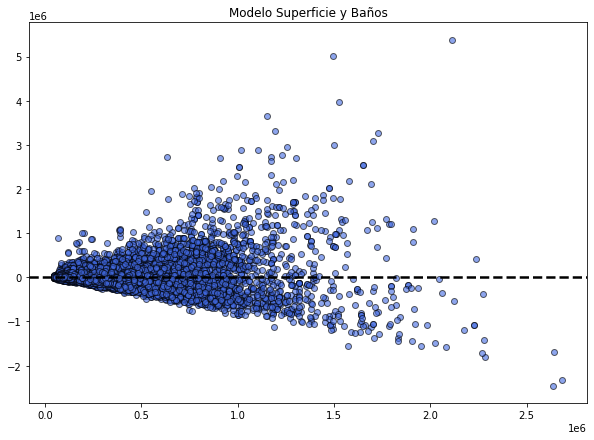

In [ ]:
# Realizamos el gráfico
plt.figure(figsize=(10,7))
plt.scatter(x=y_train_sup_baños, y=residuos_sup_baños,
            alpha=0.6, c='royalblue', edgecolor='black')
plt.axhline(y=0, c='black', ls='--', linewidth=2.5)
plt.title("Modelo Superficie y Baños");

In [ ]:
# Calculamos los residuos para el modelo de interacción
residuos_interaccion =  y_train - y_train_interaccion 

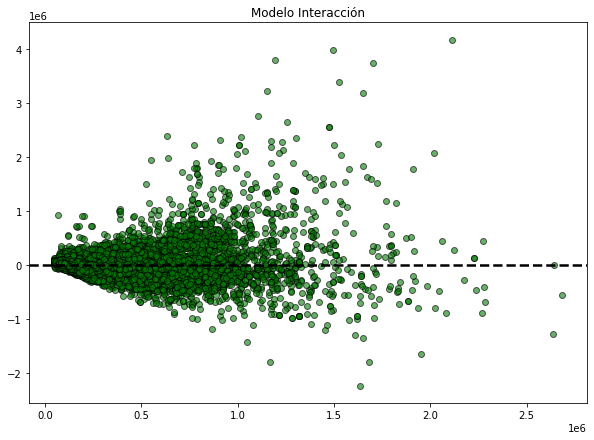

In [ ]:
# Realizamos el gráfico
plt.figure(figsize=(10,7))
plt.scatter(x=y_train_sup_baños, y=residuos_interaccion,
            alpha=0.6, c='green', edgecolor='black')
plt.axhline(y=0, c='black', ls='--', linewidth=2.5)
plt.title("Modelo Interacción");